In [1]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

# pd.set_option('display.max_columns', None) # show all columns

In [2]:
main_dfs = {}
individual_dfs = {}

OPPONENT_STATS = "teams_vs"
SQUAD_STATS = "teams"

for data_category in [SQUAD_STATS, OPPONENT_STATS]:
    individual_dfs[data_category] = {}
    for year in range(1992, 2023):
        try:
            individual_dfs[data_category][year] = pd.read_csv(
                f"./data/{data_category}/raw/PL{year}_{data_category}.csv",
                encoding='utf-8'
            )
        except FileNotFoundError:
            pass
   
    if data_category == OPPONENT_STATS:
        print("The following stats were only available from 2017 onwards;" +
        "they have been omitted from the combined dataframe for simplicity:")
        print(list(set(individual_dfs[OPPONENT_STATS][2017].columns) - set(individual_dfs[OPPONENT_STATS][2016].columns)))

    if len(individual_dfs[data_category].values()) > 0:
        main_dfs[data_category] = pd.concat(
            individual_dfs[data_category].values(),
            join="inner",
            ignore_index=True
        )

The following stats were only available from 2017 onwards;they have been omitted from the combined dataframe for simplicity:
['progressive_passes', 'npxg_xg_assist', 'npxg_per_shot', 'aerials_won_pct', 'ball_recoveries', 'xg_xg_assist_per90', 'progressive_carries', 'xg_assist_per90', 'npxg_net', 'aerials_lost', 'xg', 'xg_assist', 'pass_xa', 'npxg_per90', 'npxg', 'xg_net', 'npxg_xg_assist_per90', 'shots_free_kicks', 'aerials_won', 'progressive_passes_received', 'xg_per90']


In [3]:
# Normalize data so features have same scale, such that the model will not
# give different weights to different features based on their range
# Only team name has values of type string; rest are numeric
excluded_cols = ['season_start_year', 'season_end_year', 'squad']

scaler = StandardScaler()
# encoder = OrdinalEncoder()
    
for data_category, df in main_dfs.items():
        
    df_excluded = df.drop(columns=excluded_cols)
    df_non_numeric = df_excluded.select_dtypes(exclude=[np.number])
    df_numeric = df_excluded.select_dtypes(include=[np.number])

    # encoded_df = pd.DataFrame(
    #     encoder.fit_transform(df_non_numeric),
    #     columns=df_non_numeric.columns,
    #     index=df.index
    # )
    # encoded_df = pd.concat([encoded_df, df_numeric], axis=1)
    
    scaled_df = pd.DataFrame(
        scaler.fit_transform(encoded_df),
        columns=encoded_df.columns,
        index=df.index
    )
    pd.DataFrame(pd.concat([scaled_df, df[excluded_cols]], axis=1)) \
        .to_csv(f"./data/machine_learning/train_{data_category}.csv",index=False)

In [4]:
encoded_dfs = {} # all non-numeric encoded, then all columns scaled to normal distribution
raw_dfs = {}

OPPONENT_STATS = "teams_vs"
SQUAD_STATS = "teams"

for data_category in [SQUAD_STATS, OPPONENT_STATS]:
    try:
        encoded_dfs[data_category] = pd.read_csv(
            f"./data/machine_learning/train_{data_category}.csv",
            encoding='utf-8'
        )
        raw_dfs[data_category] = pd.read_csv(f"./data/{data_category}/{data_category}.csv")
    except FileNotFoundError:
        pass

In [5]:
# This can be found in the data_processing file; please feel free to delete from here
# Main dataframe combines all these columns across all years, dropping duplicates

# Dropped columns (as these stats are only available from 2017)
DROPPED = [
    'pass_xa', 'ball_recoveries', 'aerials_lost', 'progressive_passes', 'npxg_per_shot',
    'progressive_carries', 'progressive_passes_received', 'xg_per90', 'npxg_xg_assist_per90',
    'aerials_won_pct', 'npxg_per90', 'npxg_xg_assist', 'xg_xg_assist_per90', 'xg', 'npxg_net',
    'xg_assist', 'xg_assist_per90', 'xg_net', 'npxg', 'aerials_won', 'shots_free_kicks'
]
# Columns pulled from team tables
STANDARD = [
    'players_used', 'avg_age', 'possession', 'games',
    'games_starts', 'minutes', 'minutes_90s', 'goals', 'assists',
    'goals_assists', 'goals_pens', 'pens_made', 'pens_att', 'cards_yellow',
    'cards_red', 'xg', 'npxg', 'xg_assist', 'npxg_xg_assist',
    'progressive_carries', 'progressive_passes', 'goals_per90',
    'assists_per90', 'goals_assists_per90', 'goals_pens_per90',
    'goals_assists_pens_per90', 'xg_per90', 'xg_assist_per90',
    'xg_xg_assist_per90', 'npxg_per90', 'npxg_xg_assist_per90'
]
GOALKEEPING = [
    'players_used', 'gk_games', 'gk_games_starts', 'gk_minutes',
    'minutes_90s', 'gk_goals_against', 'gk_goals_against_per90',
    'gk_shots_on_target_against', 'gk_saves', 'gk_save_pct', 'gk_wins',
    'gk_ties', 'gk_losses', 'gk_clean_sheets', 'gk_clean_sheets_pct',
    'gk_pens_att', 'gk_pens_allowed', 'gk_pens_saved', 'gk_pens_missed',
    'gk_pens_save_pct'
]
ADVANCED_GOALKEEPING = [
    'players_used', 'minutes_90s', 'gk_goals_against',
    'gk_pens_allowed', 'gk_free_kick_goals_against',
    'gk_corner_kick_goals_against', 'gk_own_goals_against', 'gk_psxg',
    'gk_psnpxg_per_shot_on_target_against', 'gk_psxg_net',
    'gk_psxg_net_per90', 'gk_passes_completed_launched',
    'gk_passes_launched', 'gk_passes_pct_launched', 'gk_passes',
    'gk_passes_throws', 'gk_pct_passes_launched', 'gk_passes_length_avg',
    'gk_goal_kicks', 'gk_pct_goal_kicks_launched',
    'gk_goal_kick_length_avg', 'gk_crosses', 'gk_crosses_stopped',
    'gk_crosses_stopped_pct', 'gk_def_actions_outside_pen_area',
    'gk_def_actions_outside_pen_area_per90', 'gk_avg_distance_def_actions'
]
SHOOTING = [
    'players_used', 'minutes_90s', 'goals', 'shots',
    'shots_on_target', 'shots_on_target_pct', 'shots_per90',
    'shots_on_target_per90', 'goals_per_shot', 'goals_per_shot_on_target',
    'average_shot_distance', 'shots_free_kicks', 'pens_made', 'pens_att',
    'xg', 'npxg', 'npxg_per_shot', 'xg_net', 'npxg_net'
]
PASSING = [
    'players_used', 'minutes_90s', 'passes_completed', 'passes',
    'passes_pct', 'passes_total_distance', 'passes_progressive_distance',
    'passes_completed_short', 'passes_short', 'passes_pct_short',
    'passes_completed_medium', 'passes_medium', 'passes_pct_medium',
    'passes_completed_long', 'passes_long', 'passes_pct_long', 'assists',
    'xg_assist', 'pass_xa', 'xg_assist_net', 'assisted_shots',
    'passes_into_final_third', 'passes_into_penalty_area',
    'crosses_into_penalty_area', 'progressive_passes'
]
PASS_TYPES = [
    'players_used', 'minutes_90s', 'passes', 'passes_live',
    'passes_dead', 'passes_free_kicks', 'through_balls', 'passes_switches',
    'crosses', 'throw_ins', 'corner_kicks', 'corner_kicks_in',
    'corner_kicks_out', 'corner_kicks_straight', 'passes_completed',
    'passes_offsides', 'passes_blocked'
]
# Goal-creating actions
GCA = [
    'players_used', 'minutes_90s', 'sca', 'sca_per90',
    'sca_passes_live', 'sca_passes_dead', 'sca_take_ons', 'sca_shots',
    'sca_fouled', 'sca_defense', 'gca', 'gca_per90', 'gca_passes_live',
    'gca_passes_dead', 'gca_take_ons', 'gca_shots', 'gca_fouled',
    'gca_defense'
]
DEFENCE = [
    'players_used', 'minutes_90s', 'tackles', 'tackles_won',
    'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd',
    'challenge_tackles', 'challenges', 'challenge_tackles_pct',
    'challenges_lost', 'blocks', 'blocked_shots', 'blocked_passes',
    'interceptions', 'tackles_interceptions', 'clearances', 'errors'
]
POSSESSION = [
    'players_used', 'possession', 'minutes_90s', 'touches',
    'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd',
    'touches_att_3rd', 'touches_att_pen_area', 'touches_live_ball',
    'take_ons', 'take_ons_won', 'take_ons_won_pct', 'take_ons_tackled',
    'take_ons_tackled_pct', 'carries', 'carries_distance',
    'carries_progressive_distance', 'progressive_carries',
    'carries_into_final_third', 'carries_into_penalty_area', 'miscontrols',
    'dispossessed', 'passes_received', 'progressive_passes_received'
]
MISCELLANEOUS = [
    'players_used', 'minutes_90s', 'cards_yellow', 'cards_red',
    'cards_yellow_red', 'fouls', 'fouled', 'offsides', 'crosses',
    'interceptions', 'tackles_won', 'pens_won', 'pens_conceded',
    'own_goals', 'ball_recoveries', 'aerials_won', 'aerials_lost',
    'aerials_won_pct'
]

In [6]:
encoded_df_teams = raw_dfs['teams']
encoded_df_teams = encoded_dfs['teams']
encoded_df_teams_vs = raw_dfs['teams_vs']
encoded_df_teams_vs = encoded_dfs['teams_vs']

ALL_FEATURES = list(set(STANDARD + GOALKEEPING + ADVANCED_GOALKEEPING + SHOOTING + PASSING + PASS_TYPES + GCA + DEFENCE + POSSESSION + MISCELLANEOUS) - set(DROPPED))
all_features = pd.Series(ALL_FEATURES)
all_features

0      tackles_interceptions
1                      games
2                   pens_won
3          gk_psxg_net_per90
4            passes_received
               ...          
155               challenges
156              gk_psxg_net
157          tackles_def_3rd
158             dispossessed
159                  minutes
Length: 160, dtype: object

In [7]:
encoded_df_teams[ALL_FEATURES]

,tackles_interceptions,games,pens_won,gk_psxg_net_per90,passes_received,fouled,cards_red,passes_completed,gk_clean_sheets,assists_per90,...,passes_pct,take_ons_won_pct,clearances,gk_passes,touches_mid_3rd,challenges,gk_psxg_net,tackles_def_3rd,dispossessed,minutes
0,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.700841,-0.467142,1.250261,-0.313166,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
1,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-1.236526,-0.467142,0.998033,0.232375,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
2,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,0.370530,-0.467142,2.006945,1.066733,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
3,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.165155,-0.467142,-0.010879,0.136103,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
4,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.700841,-0.467142,-0.010879,-0.858707,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2.009239,-0.343303,0.970044,-2.713073,1.085044,1.852948,-1.236526,1.088156,-0.767563,-1.051251,...,1.812950,1.514312,2.331332,2.063611,1.153073,1.925938,-2.683545,2.604408,1.407481,-0.343303
622,2.338166,-0.343303,0.970044,-7.625641,1.538900,1.779604,-1.236526,1.540582,-1.776475,-0.794526,...,1.980181,1.648666,2.058086,2.483183,1.631719,2.037304,-7.637836,2.580065,2.265862,-0.343303
623,1.888055,-0.343303,1.906432,-2.303693,2.137912,1.626803,0.370530,2.135940,-0.263107,0.970461,...,2.176924,1.572532,1.790780,1.657317,1.943249,1.884691,-2.324539,2.158117,1.963712,-0.343303
624,2.029024,-0.343303,2.374627,-0.120329,1.545468,1.400658,-1.236526,1.548731,-0.515335,-0.794526,...,1.993297,1.335174,1.933343,1.420976,1.562673,1.835196,-0.134599,1.874113,1.970579,-0.343303


In [8]:
encoded_df_teams.groupby('season_start_year').squad.count().unique()

array([22, 20])

In [9]:
encoded_df_teams[['season_start_year', 'squad', *ALL_FEATURES]]

,season_start_year,squad,tackles_interceptions,games,pens_won,gk_psxg_net_per90,passes_received,fouled,cards_red,passes_completed,...,passes_pct,take_ons_won_pct,clearances,gk_passes,touches_mid_3rd,challenges,gk_psxg_net,tackles_def_3rd,dispossessed,minutes
0,1992,Arsenal,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.700841,-0.467142,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
1,1992,Aston Villa,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-1.236526,-0.467142,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
2,1992,Blackburn,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,0.370530,-0.467142,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
3,1992,Chelsea,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.165155,-0.467142,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
4,1992,Coventry City,-0.483684,2.912876,-0.434538,0.152591,-0.467000,-0.530740,-0.700841,-0.467142,...,-0.485660,-0.483079,-0.472412,-0.477717,-0.474324,-0.482862,0.152606,-0.479060,-0.480956,2.912876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2022,Nott'ham Forest,2.009239,-0.343303,0.970044,-2.713073,1.085044,1.852948,-1.236526,1.088156,...,1.812950,1.514312,2.331332,2.063611,1.153073,1.925938,-2.683545,2.604408,1.407481,-0.343303
622,2022,Southampton,2.338166,-0.343303,0.970044,-7.625641,1.538900,1.779604,-1.236526,1.540582,...,1.980181,1.648666,2.058086,2.483183,1.631719,2.037304,-7.637836,2.580065,2.265862,-0.343303
623,2022,Tottenham,1.888055,-0.343303,1.906432,-2.303693,2.137912,1.626803,0.370530,2.135940,...,2.176924,1.572532,1.790780,1.657317,1.943249,1.884691,-2.324539,2.158117,1.963712,-0.343303
624,2022,West Ham,2.029024,-0.343303,2.374627,-0.120329,1.545468,1.400658,-1.236526,1.548731,...,1.993297,1.335174,1.933343,1.420976,1.562673,1.835196,-0.134599,1.874113,1.970579,-0.343303


In [10]:
individual_score_dfs = {}

for year in range(1992, 2023):
    try:
        individual_score_dfs[year] = pd.read_csv(
            f"./data/scores/PL{year}_scores.csv",
            encoding='utf-8'
        )
    except FileNotFoundError:
        pass

raw_scores_df = pd.concat(individual_score_dfs.values(), ignore_index=True)


In [11]:
teams_perf = set(encoded_df_teams['squad'].values)
teams_scores = set(raw_scores_df['home_team'].values).union(set(raw_scores_df['away_team'].values))

old_names = sorted(list(teams_perf - teams_scores))
new_names = sorted(list(teams_scores - teams_perf))

print(f'{len(old_names)} conflicts: {old_names}')
print(f'{len(new_names)} conflicts: {new_names}')

19 conflicts: ['Birmingham City', 'Cardiff City', 'Charlton Ath', 'Coventry City', 'Derby County', 'Hull City', 'Ipswich Town', 'Leeds United', 'Leicester City', 'Newcastle Utd', 'Norwich City', "Nott'ham Forest", 'Oldham Athletic', 'Sheffield Weds', 'Stoke City', 'Swansea City', 'Swindon Town', 'Wigan Athletic', 'Wimbledon']
19 conflicts: ['Birmingham', 'Cardiff', 'Charlton', 'Coventry', 'Derby', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Newcastle', 'Norwich', 'Nottingham', 'Oldham', 'Sheffield Wed', 'Stoke', 'Swansea', 'Swindon', 'Wigan', 'Wimbledon FC']


In [12]:
name_mapping = dict(zip(old_names, new_names))
encoded_df_teams['squad'] = encoded_df_teams['squad'].replace(name_mapping)
encoded_df_teams

,players_used,avg_age,possession,games,games_starts,minutes,minutes_90s,goals,assists,goals_assists,...,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,season_start_year,season_end_year,squad
0,0.618397,-0.399032,-0.625951,2.912876,2.727873,2.912876,2.912876,-0.652065,-0.072176,-0.398196,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Arsenal
1,-0.987896,0.144392,-0.625951,2.912876,2.727873,2.912876,2.912876,0.440820,0.514608,0.481808,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Aston Villa
2,-0.666637,-0.670745,-0.625951,2.912876,3.930348,2.912876,2.912876,1.123873,1.436697,1.285289,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Blackburn
3,1.582173,-0.489603,-0.625951,2.912876,2.059831,2.912876,2.912876,0.030988,0.430781,0.213981,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Chelsea
4,0.939656,-0.399032,-0.625951,2.912876,2.126635,2.912876,2.912876,-0.105622,-0.658960,-0.359935,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Coventry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,1.903432,-0.308461,1.010474,-0.343303,-0.211511,-0.343303,-0.343303,-0.925286,-1.078092,-1.010372,...,-0.327836,0.491386,1.852948,1.717432,0.970044,3.221957,-0.402757,2022,2023,Nottingham
622,2.867208,-1.938735,1.310775,-0.343303,-0.211511,-0.343303,-0.343303,-0.925286,-0.826613,-0.895589,...,-0.327836,0.416139,1.779604,1.383235,0.970044,0.763767,4.742674,2022,2023,Southampton
623,0.618397,0.687817,1.550146,-0.343303,-0.211511,-0.343303,-0.343303,1.260484,0.933739,1.132245,...,1.368242,0.386041,1.626803,1.717432,1.906432,1.173465,0.626329,2022,2023,Tottenham
624,-0.666637,1.231242,1.206322,-0.343303,-0.211511,-0.343303,-0.343303,-0.583759,-0.826613,-0.704284,...,-0.327836,0.075022,1.400658,1.550334,2.374627,1.992862,0.626329,2022,2023,West Ham


In [13]:
print(f"Initial Dataframe is {len(raw_scores_df)} rows")

home_df = raw_scores_df.copy()
away_df = raw_scores_df.copy()

home_df['time'] = home_df['time']
home_df['team'] = home_df['home_team']
home_df['opponent'] = home_df['away_team']
home_df['is_home'] = 1
home_df['score'] = home_df['home_score']
home_df['opponent_score'] = home_df['away_score']

away_df['time'] = away_df['time']
away_df['team'] = away_df['away_team']
away_df['opponent'] = away_df['home_team']
away_df['is_home'] = 0
away_df['score'] = away_df['away_score']
away_df['opponent_score'] = away_df['home_score']

final_scores_df = pd.concat([home_df, away_df], ignore_index=True)

# Selecting the relevant columns for the new dataframe
final_scores_df = final_scores_df[['time','team', 'opponent', 'is_home', 'score', 'opponent_score', 'season_start_year', 'season_end_year']]

final_scores_df

Initial Dataframe is 12026 rows


,time,team,opponent,is_home,score,opponent_score,season_start_year,season_end_year
0,1992-08-15 22:00:00,Southampton,Tottenham,1,0,0,1992,1993
1,1992-08-15 22:00:00,Arsenal,Norwich,1,2,4,1992,1993
2,1992-08-15 22:00:00,Chelsea,Oldham,1,1,1,1992,1993
3,1992-08-15 22:00:00,Coventry,Middlesbrough,1,2,1,1992,1993
4,1992-08-15 22:00:00,Sheffield Utd,Manchester Utd,1,2,1,1992,1993
...,...,...,...,...,...,...,...,...
24047,2023-05-28 23:30:00,Tottenham,Leeds,0,4,1,2022,2023
24048,2023-05-28 23:30:00,West Ham,Leicester,0,1,2,2022,2023
24049,2023-05-28 23:30:00,Fulham,Manchester Utd,0,1,2,2022,2023
24050,2023-05-28 23:30:00,Bournemouth,Everton,0,0,1,2022,2023


In [14]:
teams_perf_df = encoded_df_teams.add_prefix('team_')
teams_vs_perf_df = encoded_df_teams.add_prefix('opponent_')

extended_df = pd.merge(final_scores_df, teams_perf_df, how='left', left_on=['team', 'season_start_year'], right_on=['team_squad', 'team_season_start_year'])
extended_df = pd.merge(extended_df, teams_vs_perf_df, how='left', left_on=['opponent', 'season_start_year'], right_on=['opponent_squad', 'opponent_season_start_year'])
extended_df.shape

(24052, 334)

In [15]:
print(f'Original Performance DF has {len(encoded_df_teams.columns)} columns')
print(f'Original Scores DF has {len(final_scores_df.columns)} columns')
print(f'Final Dataframe should have {len(encoded_df_teams.columns) * 2 + len(final_scores_df.columns)} columns')
print(f'Final Dataframe has {len(extended_df.columns)} columns')

Original Performance DF has 163 columns
Original Scores DF has 8 columns
Final Dataframe should have 334 columns
Final Dataframe has 334 columns


In [16]:
df_sorted = extended_df.sort_values(by=['season_start_year', 'team', 'time'])
df_sorted

,time,team,opponent,is_home,score,opponent_score,season_start_year,season_end_year,team_players_used,team_avg_age,...,opponent_cards_yellow_red,opponent_fouls,opponent_fouled,opponent_offsides,opponent_pens_won,opponent_pens_conceded,opponent_own_goals,opponent_season_start_year,opponent_season_end_year,opponent_squad
1,1992-08-15 22:00:00,Arsenal,Norwich,1,2,4,1992,1993,0.618397,-0.399032,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Norwich
12038,1992-08-18 22:00:00,Arsenal,Blackburn,0,0,1,1992,1993,0.618397,-0.399032,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Blackburn
12058,1992-08-23 22:00:00,Arsenal,Liverpool,0,2,0,1992,1993,0.618397,-0.399032,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Liverpool
42,1992-08-26 22:00:00,Arsenal,Oldham,1,2,0,1992,1993,0.618397,-0.399032,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Oldham
43,1992-08-29 22:00:00,Arsenal,Sheffield Wed,1,2,1,1992,1993,0.618397,-0.399032,...,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757,1992,1993,Sheffield Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23997,2023-04-29 22:00:00,Wolves,Brighton,0,0,6,2022,2023,1.582173,-0.127320,...,-0.327836,0.401090,1.956852,1.817691,1.438238,2.812259,5.771760,2022,2023,Brighton
11986,2023-05-06 22:00:00,Wolves,Aston Villa,1,1,0,2022,2023,1.582173,-0.127320,...,-0.327836,0.350926,2.513046,1.416655,1.438238,1.992862,3.713587,2022,2023,Aston Villa
24020,2023-05-13 22:00:00,Wolves,Manchester Utd,0,0,2,2022,2023,1.582173,-0.127320,...,-0.327836,0.386041,1.284530,2.118469,0.501850,0.763767,0.626329,2022,2023,Manchester Utd
12008,2023-05-20 22:00:00,Wolves,Everton,1,1,1,2022,2023,1.582173,-0.127320,...,1.368242,0.245581,1.804052,1.617173,0.970044,1.992862,-0.402757,2022,2023,Everton


In [17]:
cols_to_drop = ['opponent', 'time', 'season_end_year', 'team_squad', 'team_season_start_year', 'opponent_squad', 'opponent_season_start_year', 'team_season_end_year', 'opponent_season_end_year']
df_sorted.drop(columns=cols_to_drop, inplace = True)
df_sorted

,team,is_home,score,opponent_score,season_start_year,team_players_used,team_avg_age,team_possession,team_games,team_games_starts,...,opponent_miscontrols,opponent_dispossessed,opponent_passes_received,opponent_cards_yellow_red,opponent_fouls,opponent_fouled,opponent_offsides,opponent_pens_won,opponent_pens_conceded,opponent_own_goals
1,Arsenal,1,2,4,1992,0.618397,-0.399032,-0.625951,2.912876,2.727873,...,-0.484565,-0.480956,-0.467000,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757
12038,Arsenal,0,0,1,1992,0.618397,-0.399032,-0.625951,2.912876,2.727873,...,-0.484565,-0.480956,-0.467000,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757
12058,Arsenal,0,2,0,1992,0.618397,-0.399032,-0.625951,2.912876,2.727873,...,-0.484565,-0.480956,-0.467000,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757
42,Arsenal,1,2,0,1992,0.618397,-0.399032,-0.625951,2.912876,2.727873,...,-0.484565,-0.480956,-0.467000,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757
43,Arsenal,1,2,1,1992,0.618397,-0.399032,-0.625951,2.912876,2.727873,...,-0.484565,-0.480956,-0.467000,-0.327836,-1.740926,-0.530740,-0.521689,-0.434538,-0.465328,-0.402757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23997,Wolves,0,0,6,2022,1.582173,-0.127320,1.545793,-0.343303,-0.211511,...,2.025703,1.743966,2.651373,-0.327836,0.401090,1.956852,1.817691,1.438238,2.812259,5.771760
11986,Wolves,1,1,0,2022,1.582173,-0.127320,1.545793,-0.343303,-0.211511,...,2.057194,2.066717,1.764022,-0.327836,0.350926,2.513046,1.416655,1.438238,1.992862,3.713587
24020,Wolves,0,0,2,2022,1.582173,-0.127320,1.545793,-0.343303,-0.211511,...,1.751283,1.531088,2.233642,-0.327836,0.386041,1.284530,2.118469,0.501850,0.763767,0.626329
12008,Wolves,1,1,1,2022,1.582173,-0.127320,1.545793,-0.343303,-0.211511,...,2.237142,1.579157,1.455485,1.368242,0.245581,1.804052,1.617173,0.970044,1.992862,-0.402757


In [18]:
df_sorted['is_home'] = scaler.fit_transform(df_sorted[['is_home']])

In [19]:
SEQUENCE_LENGTH = 3
sequences = []
for _, group in df_sorted.groupby(['season_start_year', 'team']):
    for i in range(len(group) - SEQUENCE_LENGTH + 1):
        seq = group.iloc[i:i+SEQUENCE_LENGTH]
        sequences.append(seq)

In [20]:
label_columns = ['score', 'opponent_score']
feature_columns = [feature for feature in df_sorted.columns if feature not in ['team', 'season_start_year', *label_columns]]
N_FEATURES = len(feature_columns)
print(N_FEATURES)

321


In [58]:
from sklearn.model_selection import train_test_split

# Flatten sequences if necessary
X = []  # features
y = []  # [[score1, opponent_score1], [score2, opponent_score2], ...]

for sequence in sequences:
    # 'sequence' is a DataFrame representing a single sequence
    features = sequence[feature_columns].values
    labels = sequence[label_columns].values[-1] # only include last result
    
    # Append to your lists
    X.append(features)
    y.append(labels)

X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

# Verify the shape of X
print("Shape of X:", X.shape)
print("Expected shape: (num_samples, SEQUENCE_LENGTH, N_FEATURES)")

# Verify the shape of y
print("Shape of y:", y.shape)
print("Expected shape: (num_samples, 2)")

# Assuming 'X' and 'y' are prepared from your sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Shape of X: (22800, 3, 321)
Expected shape: (num_samples, SEQUENCE_LENGTH, N_FEATURES)
Shape of y: (22800, 2)
Expected shape: (num_samples, 2)


In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


2024-03-07 06:31:20.730942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 06:31:20.753422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 06:31:20.753452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 06:31:20.754179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 06:31:20.759085: I tensorflow/core/platform/cpu_feature_guar

In [23]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQUENCE_LENGTH, N_FEATURES)))
model.add(Dense(2, activation='relu'))  # Predicting goals for both teams
model.compile(optimizer='adam', loss='mse')

2024-03-07 06:31:22.368348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 06:31:22.399896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 06:31:22.399952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 06:31:22.403457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 06:31:22.403524: I external/local_xla/xla/stream_executor

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                74400     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 74502 (291.02 KB)
Trainable params: 74502 (291.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from tensorflow.keras.utils import plot_model

# This saves a PNG image of your model architecture to a file
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Create a logs directory with a timestamp to organize training runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/100


2024-03-07 06:31:26.257790: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eff2c35eb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 06:31:26.257835: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-07 06:31:26.262342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 06:31:26.564432: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1709764286.623239   55539 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 [==============================] - 6s 7ms/step - loss: 1.3258 - val_loss: 1.4398
Epoch 2/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2611 - val_loss: 1.4236
Epoch 3/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2542 - val_loss: 1.4319
Epoch 4/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2497 - val_loss: 1.4035
Epoch 5/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2461 - val_loss: 1.4001
Epoch 6/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2446 - val_loss: 1.3866
Epoch 7/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2397 - val_loss: 1.3776
Epoch 8/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2409 - val_loss: 1.3762
Epoch 9/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2363 - val_loss: 1.3814
Epoch 10/100
456/456 [==============================] - 3s 6ms/step - loss: 1.2367 - val_loss: 1.3709
E

In [27]:
!tensorboard --logdir logs/fit --bind_all

2024-03-07 06:36:08.058436: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 06:36:08.088969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 06:36:08.089027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 06:36:08.089788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 06:36:08.094215: I tensorflow/core/platform/cpu_feature_guar

In [55]:
y_pred = model.predict(X_test)  # Model predictions
y_pred = scaler.inverse_transform(y_pred_scaled)  # Inverse transform predictions
y_pred = np.rint(y_pred).astype(int)

143/143 [==============================] - 0s 3ms/step


In [66]:
def outcomes_from_scores(scores):
    # Assuming scores is an array of shape (n_samples, 2) where scores[:, 0] is the predicted scores for the home team
    # and scores[:, 1] is for the away team
    outcomes = ['win' if team_score > opponent_score else 'draw' if team_score == opponent_score else 'lose' for team_score, opponent_score in scores]
    for i, (team_score, opponent_score) in enumerate(scores):
        if i > 0 and i < 100:
            print(f"team score: {team_score}, opponent score: {opponent_score}")
    return outcomes

y_pred_outcomes = outcomes_from_scores(y_pred)
# y_test_outcomes = outcomes_from_scores(y_test)

team score: 0, opponent score: 0
team score: 1, opponent score: 1
team score: 1, opponent score: 2
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 0, opponent score: 0
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 0, opponent score: 2
team score: 1, opponent score: 1
team score: 0, opponent score: 2
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 0, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 2
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 2
team score: 1, opponent score: 1
team score: 0, opponent score: 2
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score: 1, opponent score: 1
team score

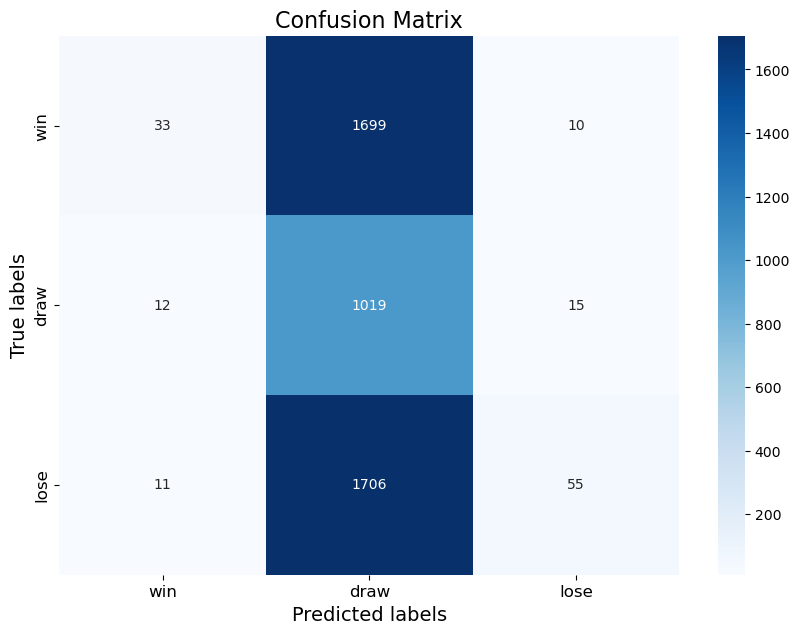

Accuracy: 0.24276315789473685


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

conf_matrix = confusion_matrix(y_test_outcomes, y_pred_outcomes, labels=["win", "draw", "lose"])

fig, ax = plt.subplots(figsize=(10, 7)) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=["win", "draw", "lose"], yticklabels=["win", "draw", "lose"])

# Labels, title, and ticks
label_font = {'size':'14'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix', fontdict={'size':'16'}) 
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test_outcomes, y_pred_outcomes)
print("Accuracy:", accuracy)

In [ ]:
# model = Sequential()
# # Assuming M is the number of features after preprocessing and Dense layers
# model.add(Dense(64, activation='relu', input_shape=(38, M)))  # Dense layer example
# model.add(LSTM(128, return_sequences=False))  # LSTM layer
# model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes: win/loss/draw

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])